# ASTR 596: FDS Homework 4 - Monte Carlo Basics

We've already looked at the simple, most general Monte Carlo algorithm, and you used it on your last homework set.

## Simple Monte Carlo

A posterior is already naturally factored into a likelihood function and a prior PDF.

## $$p(\theta|x) \propto p(x|\theta)\,p(\theta)$$

Applying this in the MC integration context leads to the Simple Monte Carlo algorithm:

```
while we want more samples
    draw theta from p(theta)
    compute weight = p(x|theta)
    store theta and weight
```

Obtaining marginal distribution(s) for $\theta$ then reduces to constructing weighted histograms of the samples.

SMC is indeed simple (as long as the prior is simple to draw from), but if the priors are not very informative then it still wastes many likelihood evaluations where the posterior is small. 

However, refinements of this approach lead to some more advanced algorithms. Once class of refinements is in how the samples are drawn:

### Rejection sampling
For this method, we need to define an *envelope function* which everywhere exceeds the target PDF, $p(x)$, and can be sampled. Let this be $Ag(x)$ where $A$ is a scaling factor and $g(x)$ is a PDF we know.

Then the algorithm is
```
while we want more samples
    draw x from g(x)
    draw u from Uniform(0,1)
    if u <= p(x)/(A*g(x)), keep the sample x
    otherwise, reject x
```

# Problem 1: Rejection Sampling

Implement a rejection sampler corresponding to the example figure above that illustrates the method. For this example,

* $p(x)$ is the $\chi^2$ distribution with 3 degrees of freedom

* $A=\pi$

* $g(x)$ is a normal distribution with mean 0 and standard deviation 5

Verify that your samples do indeed approximate the target PDF.

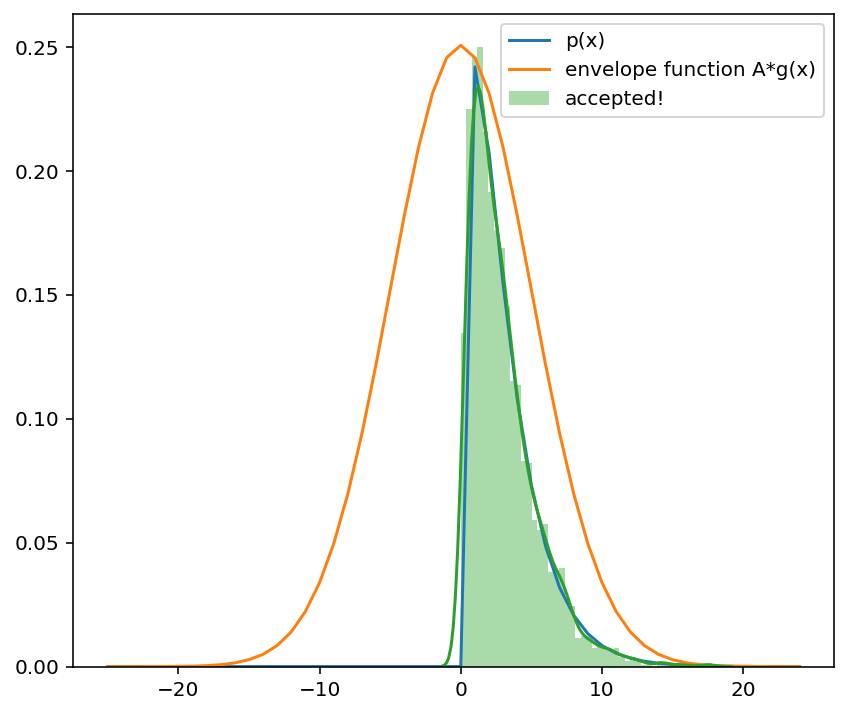

In [1]:
# YOUR CODE HERE
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2

x = np.arange(-25, 25)
A = np.pi 

def p(x):
    return st.chi2.pdf(x, df=3)

def g(x):
    return st.norm.pdf(x, loc=0, scale=5)

def rejection_sampling(iter=1000):
    sample_list = []

    for i in range(iter):
        z = np.random.normal(loc=0, scale=5) #draw x from g(x)
        u = np.random.uniform(0, 1) # draw u from Uniform(0,1)

        if u <= p(z)/(A*g(z)): #if u <= p(x)/(A*g(x)), keep the sample x
            sample_list.append(z)
            
        # otherwise, reject x
        # or just don't code it :p
        
    return np.array(sample_list) #good samples

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)

ax1.plot(x, p(x), label='p(x)')
ax1.plot(x, A*g(x), label='envelope function A*g(x)')
s = rejection_sampling(iter=10000)
sns.distplot(s, label='accepted!')
plt.legend(loc='best')

This technique is at the heart of a  very widely used (by scientists anyway) and simple to implement technique: the **Metropolis-Hastings** algorithm, which is one example of *Markov Chain Monte Carlo.*

### Markov Chains

A Markov Chain is a sequence where the $n$th entry depends explicitly on the $(n-1)$th, but not (explicitly) on previous steps. The chain will be a random walk through parameter space.


### Formalities of MCMC

Markov chains provide a powerful way to sample PDFs, provided that the transition kernel/proposal distribution - how we go from state 1 to state 2  satisfies a few requirements
* Detailed balance: any transition must be reversible; the probability of being at $x$ and moving to $y$ must equal the probability of being at $y$ and moving to $x$
* Ergodicity: the process may not be periodic, but it nevertheless must be possible to return to a given state in finite time
* It must be possible, in principle, to reach any state with non-zero prior probability

#### Why does it work?
The probability of an arbitrary point from such a chain being located at $x'$ is (marginalizing over the possible immediately preceding points)

## $$p(y) = \int dx \, p(x) \, T(x'|x)$$

where $T(y|x)$ is the transition probability of a step from $x$ to $x'$.

If we have detailed balance, 

## $$p(x)T(x'|x) = p(x')T(x|x')$$

rearranging:

## $$ \frac{T(x'|x)}{T(x|x')} = \frac{p(x')}{p(x)} $$

The basic trick to connect this with rejection sampling is to break the transition into two steps:
1. A proposal, g(x'| x)
and 
2. Acceptance ratio, A(x'|x)

i.e. 

## $$ T(x'|x) = A(x'|x) g(x'| x) $$ 

rearranging again :

## $$ \frac{A(x'|x)}{A(x|x')} = \frac{p(x')g(x|x')}{p(x)g(x'|x) }$$


## Metropolis-Hastings
This algorithm can be thought of as an MCMC adaptation of rejection sampling. We need to define
1. An initial state (parameter values)
2. A proposal distribution, $g(x'|x)$, giving the probability that we attempt to move from $x$ to $x'$.

Let $P$ be the distribution we want to sample. The algorithm is then
```
set x to an initial state
compute p(x)
while we want more samples
    draw y from g(x'|x)
    compute p(x')
    draw u from Uniform(0,1)
    if u <= p(x')/p(x) * g(x|x')/g(x'|x), set the state x=x'
    otherwise, x stays the same
    store x as a sample
```

Compare this to the rejection sampling algorithm above!

Notice that the probability of accepting a step  (once it's proposed) is

## $$A(x',x) = \mathrm{min}\left[1, \frac{p(x')g(x|x')}{p(x)g(x'|x)}\right]$$

Let's look again at the requirement of detailed balance

> the probability of being at $x$ and moving to $y$ must equal the probability of being at $y$ and moving to $x$

The first of these is $p(x)g(x'|x)A(x',x)$, where

* $p(x)$ is the posterior density (probability of *being* at $x$, if we're sampling $P$ properly)

* $g(x'|x)$ is the proposal distribution (probability of attempting a move to $y$ from $x$)

* $A(x',x)$ is the probability of accepting the proposed move

With this definition of $A$, detailed balance is automatically satisfied!

## $$p(x)g(x'|x)A(x',x) \equiv p(x')g(x|x')A(x,x')$$

Note that **even if a step is rejected, we still keep a sample** (the original state, without moving). The difficulty of finding a temptingly better point is important information!


### Metropolis
If the proposal distribution is translation invariant (i.e. only depends on the distance between the points), $g(x'|x)=g\left(\left|x'-x\right|\right)$, then it drops out of the *acceptance ratio* that decides whether to accept a step. 

**The most basic choice you can make is a Gaussian.**

For an N-dimensional Gaussian proposal function, $g$,  an *acceptance fraction* $A$ of $\sim25\%$ is optimal.

## $$A(x',x) = \mathrm{min}\left[1, \frac{p(y)}{p(x)}\right]$$

This is the original Metropolis algorithm, and is the easiest case to implement.

In this case, we *always* accept a jump to higher $p$, and *sometimes* accept one to lower $p$.

You'll have to tune the $\sigma$ of your Gaussian proposal function g by hand to make sure that your get a ~25% acceptance ratio. Note that this sigma is simply telling you the distribution of $x'$ from $x$.

# Problem 2: Metropolis


You guessed it... Implement the Metroplis Hastings algorithm in python.
Your implementation should accept an arbitary function as an argument (just as you've been passing to `scipy.optimize`)

Test it by sampling both the `circle` and `pgauss` function below 10,000 times and plotting your samples as you did in class (don't plot up your rejected). You can implement a prior function that imposes bounds. 

Look at your first 100 samples and then samples 500 to 600 for the `pgauss` case and comment on the difference. Think about this on Problem 3!

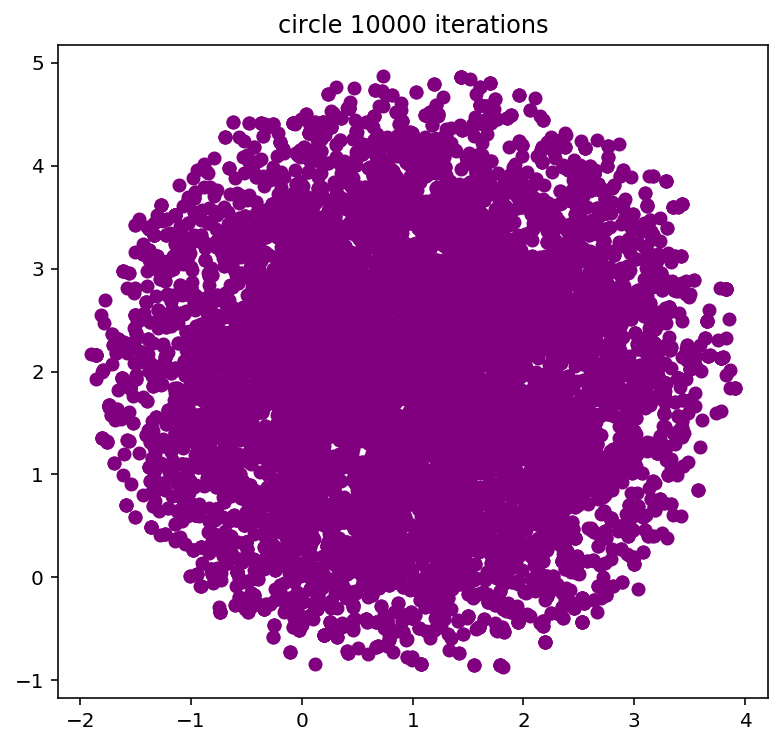

In [2]:
# YOUR CODE HERE

#the following is defined for us
def circle(x, y):
    return (x-1)**2 + (y-2)**2 - 3**2

mus = np.array([5, 5])
sigmas = np.array([[1, .9], [.9, 1]])

def pgauss(x, y):
    return st.multivariate_normal.pdf([x, y], mean=mus, cov=sigmas)

#set a function called g
def g(x, y):
    return st.norm.pdf([x, y], loc=0, scale=1)

def metropolis_hastings(p, iter=1000): #accept arbitrary func "p"
    x, y = 0, 0  # set x to initial state; that is, initial (x,y) setting. This computes p(x)
    samples_list = np.zeros((iter, 2)) 

    for i in range(iter):
        x_new, y_new = np.array([x, y]) + np.random.normal(loc=0, scale=1, size=2) #draw "y" from g(x'|x) ... "y" is like new guess
        samples_list[i] = np.array([x_new, y_new]) #compute p(x')
        
        u = np.random.uniform(0, 1) # draw u from Uniform(0,1)
        
        if u < (p(x_new, y_new) / p(x, y)) * (g(x, y)/g(x_new, y_new)).all():
            x, y = x_new, y_new #accept sample and set state x=x'
        samples_list[i] = np.array([x, y]) 
            
        #reject other samples by ignoring them :p

    return samples_list


fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)

samples_list = metropolis_hastings(circle, iter=10000)
ax1.set_title('circle 10000 iterations')
ax1.scatter(samples_list[:, 0], samples_list[:, 1], color='purple')

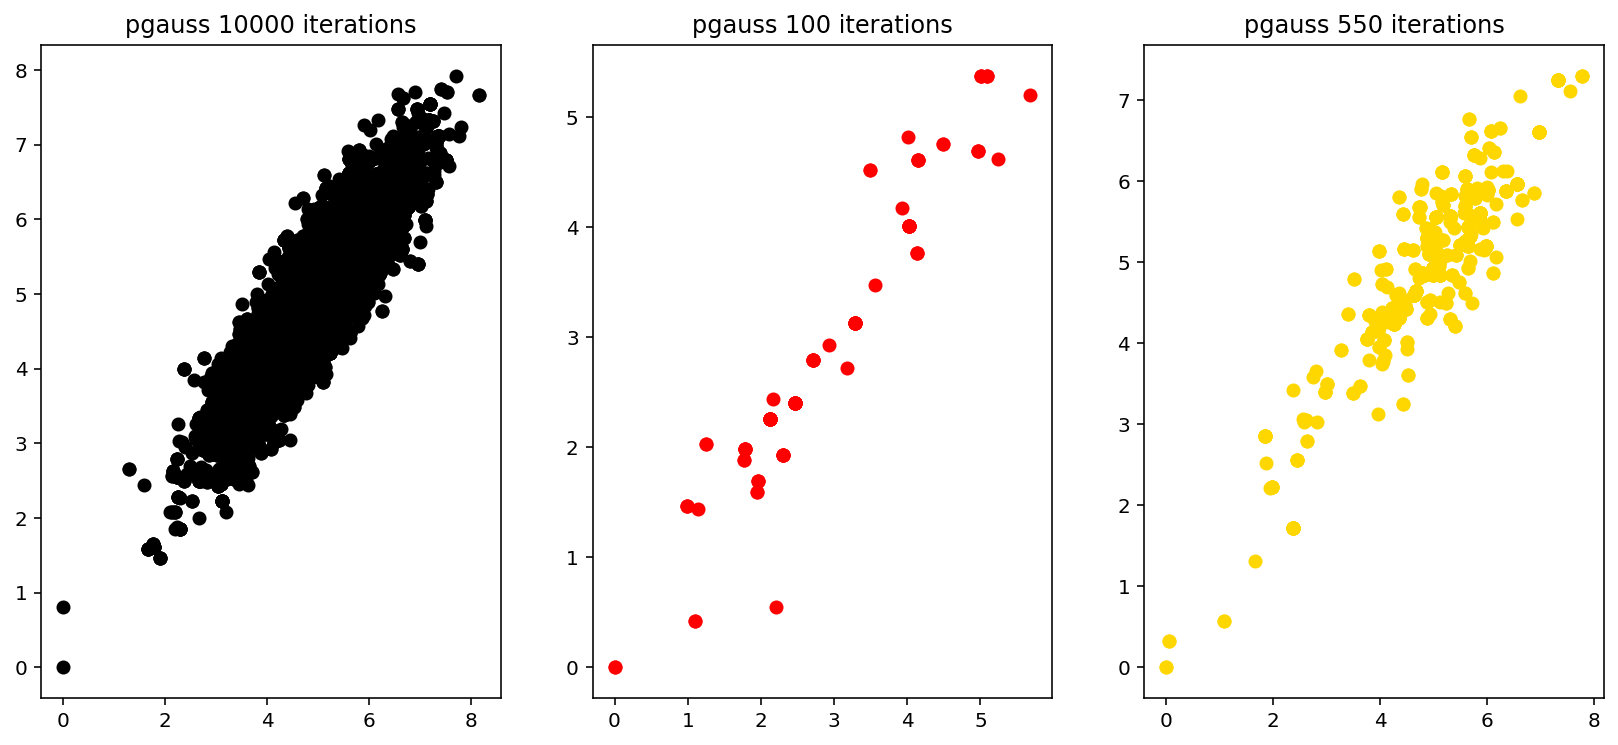

In [3]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

samples_list = metropolis_hastings(pgauss, iter=10000)
ax1.set_title('pgauss 10000 iterations')
ax1.scatter(samples_list[:, 0], samples_list[:, 1], color='black')
    
samples_list = metropolis_hastings(pgauss, iter=100)
ax2.set_title('pgauss 100 iterations')
ax2.scatter(samples_list[:, 0], samples_list[:, 1], color='red')
    
samples_list = metropolis_hastings(pgauss, iter=550)
ax3.set_title('pgauss 550 iterations')
ax3.scatter(samples_list[:, 0], samples_list[:, 1], color='gold')

## Problem 3: Using your sampler for a real problem where a grid would have been really painful.


We'll be analyzing data from the Optical Gravitational Lensing Experiment (OGLE), which monitors stars in our galaxy in the hopes of detecting gravitational microlensing events that occur when a compact mass (e.g. a fainter star) passes in front of the monitored star.

You can read more about microlensing here if you like:
https://en.wikipedia.org/wiki/Gravitational_microlensing

Data are available through the [OGLE Early Warning System](http://ogle.astrouw.edu.pl/ogle4/ews/ews.html). Scroll down a bit to the list of recent events and choose one to analyze. (Not the one shown below. Be original.) The event summary page will include a plot like this.

<table>
    <tr>
        <td><img src="http://ogle.astrouw.edu.pl/ogle4/ews/2019/data/2019/blg-0001/lcurve.gif" width=75%></td>
    </tr>
</table>

As long as a vaguely reasonable looking magenta line is shown, this should be a good data set to fit. Download the `phot.dat` for your chosen event (linked at the bottom of the webpage).

As described on the OGLE page, the columns of this text file are

> Hel.JD, I magnitude, magnitude error, seeing estimation (in pixels - 0.26"/pixel) and sky level

* Heliocentric Julian Date. This is time, measured in days, since a fixed reference. The "heliocentric" part means that it has been corrected to the reference frame of the Sun, i.e. the few minutes of light travel time more or less that would affect photon arrivals at different parts of the Earth's year have been subtracted off.

* Measurements of magnitude in the $I$ band (a near infrared band). Recall that astronomical magnitude, relative to a given reference source, is given by the relationship $m = m_\mathrm{ref} - 2.5\,\log_{10}\left(\frac{F}{F_\mathrm{ref}}\right)$, where $F$ is flux.

* Measurement uncertainty on the $I$ magnitude, defined in some unspecified way (digging through papers might elucidate this).

* The "seeing" and "sky level" quantities refer to the observing conditions, which we will not work with directly. These will have been accounted for (somehow) in deriving the best-fitting magnitude and its uncertainty.


As Bayesian's we have 4 questions to answer
1. What's the model?
2. What's the Likelihood?
3. What's the Prior?
4. How do you sample?


I'll tell you 1. and you've already written down the answer to 4.


## $$F(t) = F_0 \frac{u(t)^2 + 2}{u(t)\sqrt{u(t)^2+4}}$$

where

## $$u(t) = \sqrt{p^2 + \left( \frac{t-t_\mathrm{max}}{t_\mathrm{E}} \right)^2}$$

You'll of course also need the transformation between flux and magnitude, above. For convenience, let's parameterize the normalization of the model lightcurve in magnitudes rather than flux, i.e. $I_0$ rather than $F_0$; that way, all of the "ref" quantities in the magnitude definition are absorbed into this new parameter and we won't have to worry about them explicitly. With that substitution, the model parameters are $I_0$, $p$, $t_\mathrm{max}$ and $t_\mathrm{E}$. 

* $t_\mathrm{E}$ is the Einstein crossing time - you can also get some initial guess for this from the data itself

* $t_\mathrm{max}$ is the time of maximum - which you should be able to read off from the plot

* $p$ is the peak magnification - You can also get a guess of this and $I_0$ from the data. Look at the functional form of the model at times far from $t_\mathrm{max}$.


Lacking any better information, we'll assume that the sampling distributions for the magnitude measurements are Gaussian and independent, with means given by the "magnitude" column and standard deviations given by the "magnitude error" column, and that the time stamps are exact.


Do an MCMC fit of this microlensing model to your lightcurve data
This fit should be doable, if potentially annoying, with your Metropolis-Hastings implementation.

Your solution should include the following:

1. expressions (in readable code, at a minimum) of the prior distributions and likelihood encoded (i.e. Q2 for a Bayesian)
2. some justification of the choice of priors (Q3. for a Bayesian can be brief)
3. plots showing traces of each parameter, and an identified burn-in period
4. some evaluation of how well the fit has converged (see below)
5. 1D histograms of the parameter samples and 2D contour plots of parameter pairs (you can just use the `corner` package for this, which makes it trivial - you can see how in homework from week 1)
6. "best fit" values and 68.3% confidence intervals from the 1D marginalized posteriors of each parameter. 
7. a plot of the best-fitting model lightcurve over the data, and some qualitative comments about how good a fit it appears (hint: depending on your data set, you may need to zoom in quite a lot to get a good look)

In [7]:
# YOUR CODE HERE

import pandas as pd
import scipy.stats as st

# read the 2019-BLG-0010 data; format to make nice
df = pd.read_csv("Data4HW04/phot.dat", names=['HelJD', 'I_mag', 'mag_err', 'seeing', 'skyLevel'], delimiter=' ')

In [8]:
print(df)

             HelJD   I_mag  mag_err  seeing  skyLevel
0     2.457417e+06  13.674    0.003    7.15    1277.0
1     2.457425e+06  13.694    0.003    5.26     571.0
2     2.457426e+06  13.703    0.003    6.53     705.0
3     2.457427e+06  13.707    0.003    7.38     850.0
4     2.457428e+06  13.700    0.003    7.06     625.0
...            ...     ...      ...     ...       ...
2768  2.458784e+06  13.693    0.003    5.22     626.0
2769  2.458785e+06  13.701    0.003    7.30     627.0
2770  2.458786e+06  13.694    0.003    7.84     939.0
2771  2.458787e+06  13.688    0.003    7.05     869.0
2772  2.458788e+06  13.683    0.003    5.57     886.0

[2773 rows x 5 columns]


In [84]:
# gather best guess parameters
t_max = 2458564.76185 #time at which peak mag occurs
t_E =  37 #end - start of crossing event (in days)
I_0 = 13.68 # about average continuum line
p_mag = .66
t = df['HelJD'] 

In [85]:
#define a model for our predicted light curve using our 4 parameters and time

def model(t, p_mag, t_max, t_E, I_0):
    u_t = np.sqrt(p_mag**2 + ((t-t_max)/t_E)**2)
    F_0 = 10**(-I_0/2.5)
    F = F_0 * ((u_t**2 +2)/(u_t * np.sqrt(u_t**2 + 4)))
    I_mag = -2.5 * np.log10(F)
    return I_mag

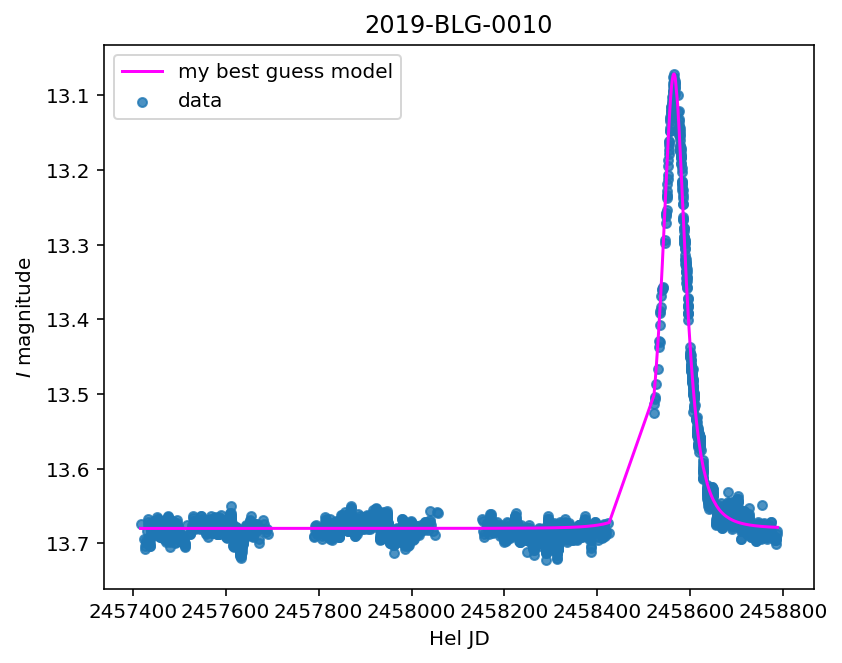

In [230]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)

I_model = model(df['HelJD'], p_mag, t_max, t_E, I_0)

ax1.invert_yaxis() # magnitudes are backward
ax1.set_ylabel('$I$ magnitude')
ax1.set_xlabel('Hel JD')
ax1.set_title('2019-BLG-0010')
ax1.plot(t, I_model, color='magenta', label='my best guess model')
ax1.scatter(df['HelJD'], df['I_mag'], s=20, alpha=0.8, label='data') 
ax1.legend()

In [231]:
# chi-2 to determine how good fit is
def chi2(I_model): 
    chisq = np.sum((I_model - df['I_mag'])**2/df['mag_err']**2)
    return chisq

In [254]:
#pick some good guess distributions for da parameters
import scipy.stats as st

p_mag_dist = st.norm.rvs(loc=p_mag, scale=.02)
t_max_dist = st.norm.rvs(loc=t_max, scale=20)
t_E_dist = st.norm.rvs(loc=t_E, scale=3)
I_0_dist = st.norm.rvs(loc=I_0, scale=.2)

#do Markov-Chain Monte Carlooooooo

def MCMC(p, iter=1000): #accept arbitrary func "p"
    w, x, y, z = p_mag_dist, t_max_dist, t_E_dist, I_0_dist
    samples_list = np.zeros((iter, 4)) 

    for i in range(iter):
        w_new, x_new, y_new, z_new = np.array([w, x, y, z]) + np.random.normal(loc=0, scale=.01, size=4) 
        I_model = model(df['HelJD'], w, x, y, z)
        shoe_posterior = chi2(I_model)*1 #proxy posterior = proxy likelihood(chi2) * prior  
        
        I_model_new = model(df['HelJD'], w_new, x_new, y_new, z_new)
        shoe_posterior_new = chi2(I_model_new)*1 #our new posterior with our new guess
        
        if shoe_posterior_new < shoe_posterior : #if model is better fit (lower likelihood), accept sample
            w, x, y, z = w_new, x_new, y_new, z_new #accept sample and set state x=x'
        samples_list[i] = np.array([w, x, y, z]) 
            
        #reject other samples by ignoring them :p

    return samples_list

samples_list = MCMC(model, iter=1000)

I expect the distributions for each parameter to be a normal distribution, centered on a best guess value from my model, with standard deviations reasonable for the magnitude of the parameter's value. Because magnitudes are measured with a CCD detector, its parameters are best distributed by a normally distributed Gaussian. 

I also set a flat prior to multiply my proxy likelihood (simply chisquare) to get the posterior ("shoe posterior" -- an injoke, but I can show you a reference picture). I chose a flat prior because I expect the model magnitude value to be equally possible within a small range of the light curve's baseline, and will give me the longest burn-in period.

MCMC model value for p is 0.6958690200271698
MCMC model value for t_max is 2458572.393436434
MCMC model value for t_E is 36.135384527381255
MCMC model value for I_0 is 13.684693829205674


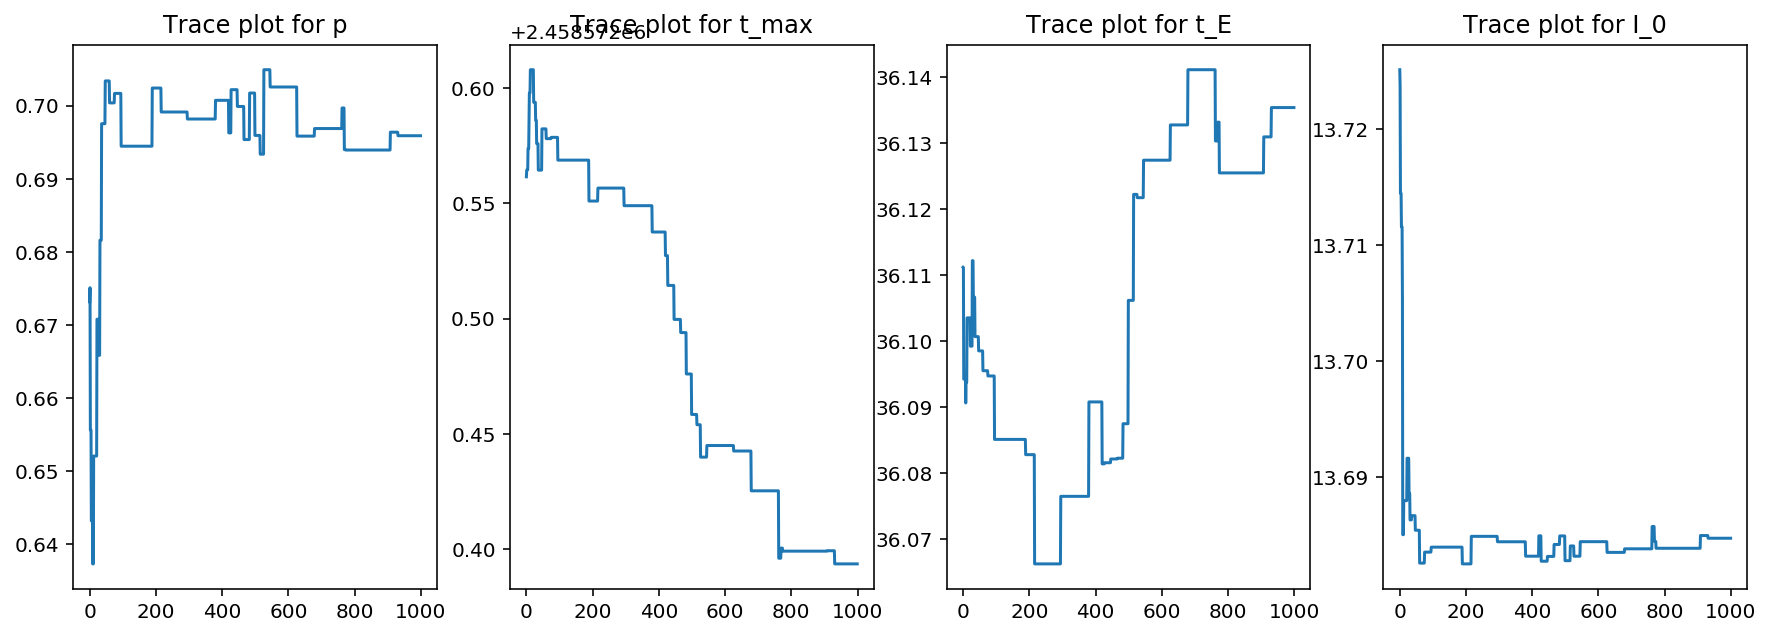

In [271]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.plot(samples_list[:,0])
ax1.set_title('Trace plot for p')

ax2.plot(samples_list[:,1])
ax2.set_title('Trace plot for t_max')

ax3.plot(samples_list[:,2])
ax3.set_title('Trace plot for t_E')

ax4.plot(samples_list[:,3])
ax4.set_title('Trace plot for I_0')

print('MCMC model value for p is', samples_list[-1,0])
print('MCMC model value for t_max is', samples_list[-1,1])
print('MCMC model value for t_E is', samples_list[-1,2])
print('MCMC model value for I_0 is', samples_list[-1,3])

Wahoo! Burn-in periods for the win. The value for $p$ and $I_0$ are most set in stone, and were burned-in early in the iteration count (less than 100). And, $t_E$ has settled seems to oscillate within 0.01 of its final value. $t_{max}$ is most uncertain, but settled close to the end of the iteration count.

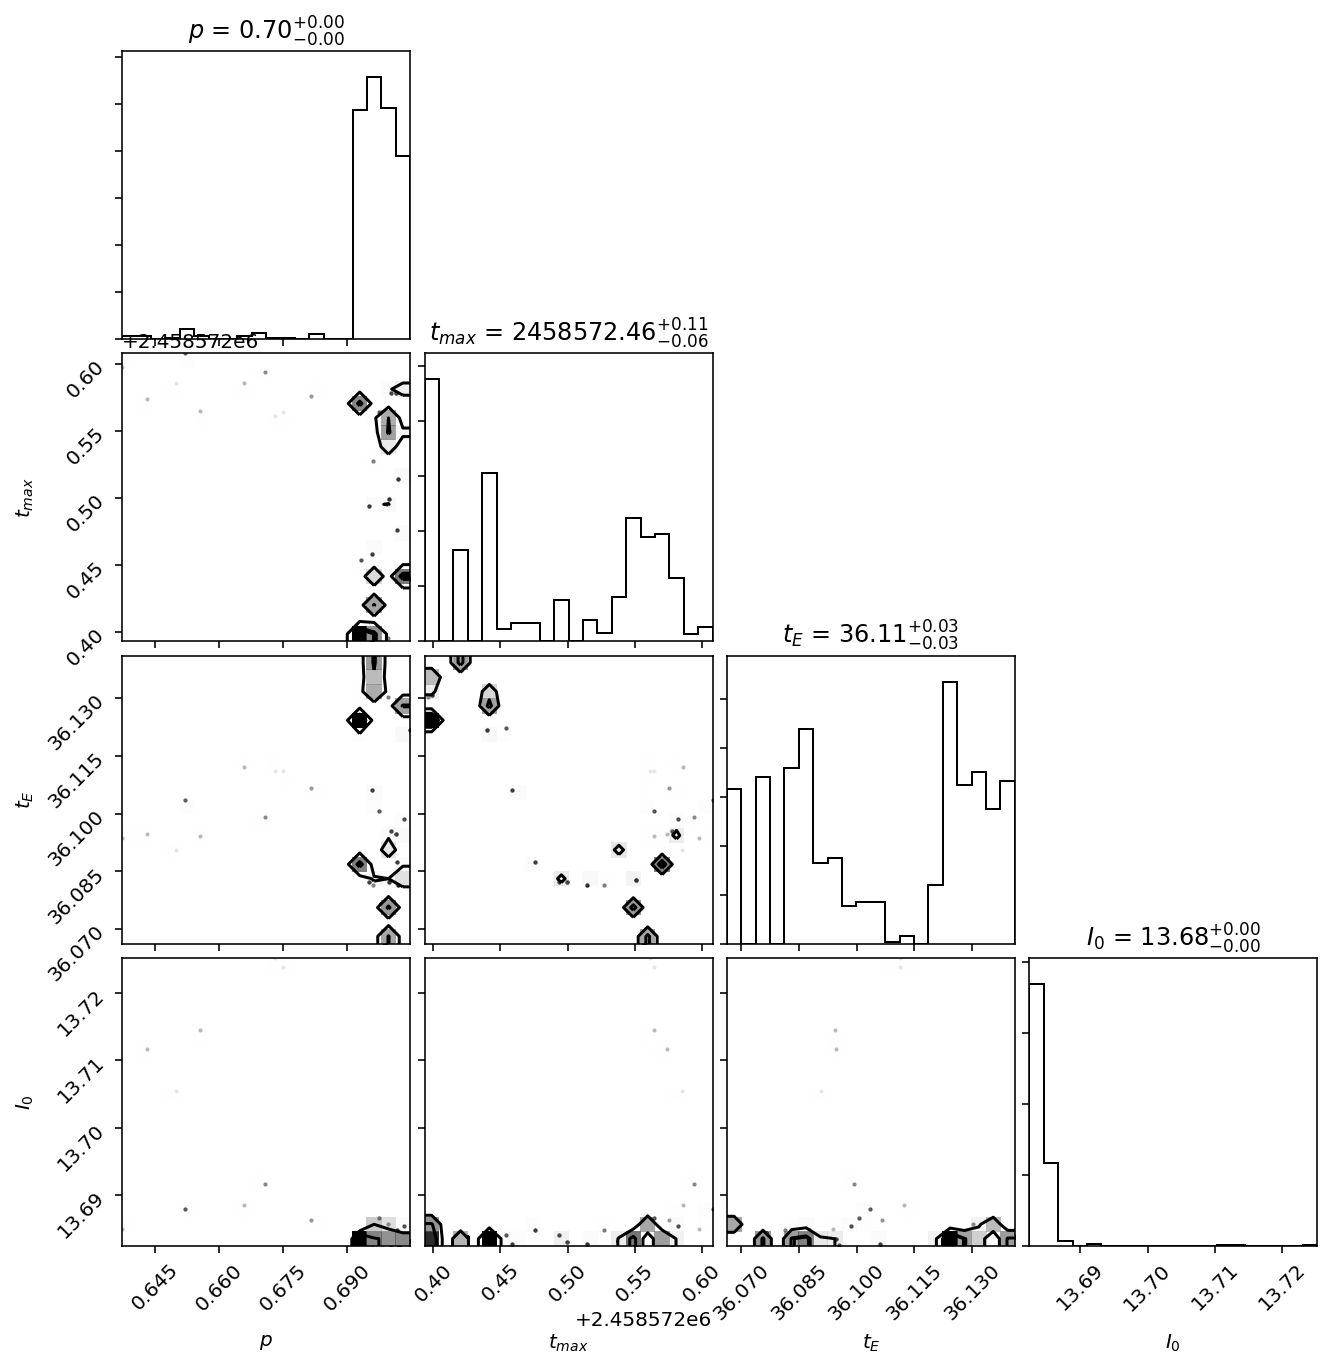

In [270]:
import corner

stack = np.stack([samples_list[:,0], samples_list[:,1], samples_list[:,2], samples_list[:,3]], axis=1)

# Plot it.
figure = corner.corner(stack, labels=[r"$p$", r"$t_{max}$", r"$t_E$", r"$I_0$"],
                       show_titles=True, title_kwargs={"fontsize": 12})

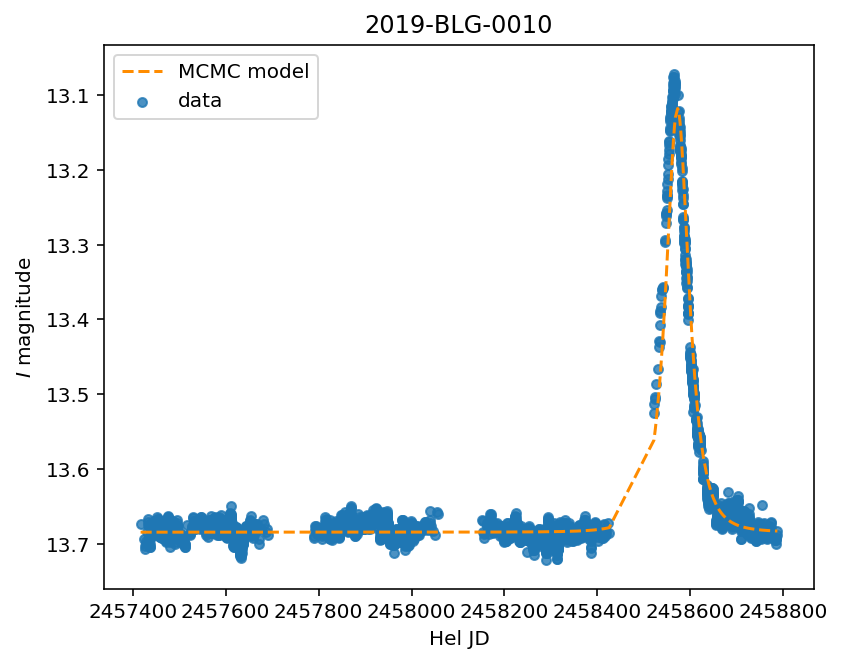

In [256]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)

I_model_best = model(df['HelJD'], samples_list[-1,0], samples_list[-1,1], samples_list[-1,2], samples_list[-1,3])

ax1.invert_yaxis() # magnitudes are backward
ax1.set_ylabel('$I$ magnitude')
ax1.set_xlabel('Hel JD')
ax1.set_title('2019-BLG-0010')
ax1.plot(t, I_model_best, '--', color='darkorange', label='MCMC model')
ax1.scatter(df['HelJD'], df['I_mag'], s=20, alpha=0.8, label='data') 
ax1.legend()

Wow! This fit looks great. Really close to my "best guess" model, but is slightly thinner, and not as peaked (as in, peaks at slightly lower value than data). Overall it fits the form of the light curve really tightly, and this proves the power of MCMC! 